Most of the codes in this notebook are from the following [Kaggle Notebook](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [1]:
import sys
import gc
import time
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from itertools import product
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

**Problem.** In a nutshell we are given daily sales for 34 months and we need to predict the sales for the 35th month.  

### Datasets

Let's first read in the datasets

In [2]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Observe that the names are in Russian. Our task is to predict the number of items sold for the latest month given the shop_id and item_id. This is a time series problem. Let's first see if there are any null values in the train set.

In [8]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### Outliers

Let's look at the ranges of item_cnt_day and item_price.

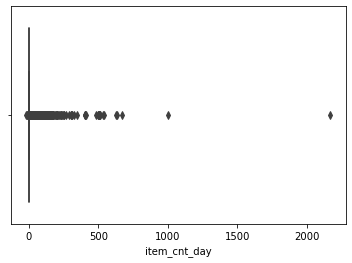

In [9]:
sns.boxplot(train['item_cnt_day'])

Observe that we have an outlier value > 2000 for item_cnt_day. Let's see how many records have this value.  

In [10]:
print(f"The number of records with item_cnt_day > 2000 is {train[train.item_cnt_day>2000].shape[0]}")

The number of records with item_cnt_day > 2000 is 1


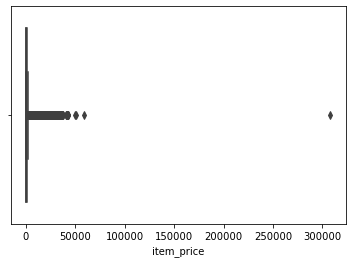

In [11]:
sns.boxplot(train['item_price'])

Observe that we have an outlier value > 250000 for item_price. Let's see how many records with this value. 

In [12]:
print(f"The number of records with item_price > 250000 is {train[train.item_price>250000].shape[0]}")

The number of records with item_price > 250000 is 1


Let's remove these two outliers from the dataset.

In [13]:
train = train[train['item_cnt_day']<2000]
train = train[train['item_price']<250000]
train = train.reset_index(drop = True)

There is only one record with item_price < 0. Replace it with the price median.

In [14]:
train.loc[train['item_price']<0, 'item_price'] = train['item_price'].median()

### Shops/Cats/Items Preprocessing

Eventhough the names are in Russian, we note that 
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [15]:
#extract the city name
shops['city'] = shops['shop_name'].map(lambda x: x.split()[0].strip('!,'))
#apply label encoder to city name
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [16]:
cats['split'] = cats['item_category_name'].map(lambda x: x.split('-'))
cats['type'] = cats['split'].map(lambda x:x[0].strip()) #strip() removes all spaces
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

#create subtype, if no subtype then use type
cats['subtype'] = cats['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


### Monthly sales

In [17]:
print(f"The number of unique items in the test set is {test.item_id.nunique()}")
print(f"The number of unique_shops in the test set is {test.shop_id.nunique()}")

The number of unique items in the test set is 5100
The number of unique_shops in the test set is 42


In [18]:
assert test.item_id.nunique()*test.shop_id.nunique() == test.shape[0]
print(f'The shape of test set is {test.shape}')

The shape of test set is (214200, 3)


Observe that we have 214200 unique (shop_id, item_id) pairs, which is the same as the size of the test set. Since the train dataset is on a daily basis we would have to aggregate it to a monthly basis. For each month we would populate all the unique (shop_id, item_id) pairs for that month, to make it similar to the test set. Note that not all the items from the test set appear in the train set. 

In [19]:
print(f"There are {len(set(test.item_id).difference(set(train.item_id)))} items in the test set not in the train set")

There are 363 items in the test set not in the train set


As a first step let us create a dataset with the months from the train set (0 to 33) and for each month we populate with all the unique (shop_id, item_id) for that month. 

In [20]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in tqdm(range(34)):
    sales = train[train['date_block_num'] == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype = 'int16'))

#concatenate the arrays to form a dataframe
matrix = pd.DataFrame(np.vstack(matrix), columns = cols)
#reduce data size
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace = True)
print(f'elapsed time is {time.time() - ts}')

matrix.head()

100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


elapsed time is 7.828887701034546


,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


Next we add the aggregated monthly sales to the above dataframe. After the merge we fill NA by 0 (no items sold for that month), clip from 0 to 20 (this is a condition specified by the organizer).

In [21]:
ts = time.time()

#aggregate monthly sale for the train data
cols = ['date_block_num', 'shop_id', 'item_id']
group = train.groupby(cols).agg({'item_cnt_day': 'sum'}).reset_index()
group.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

matrix = pd.merge(matrix, group, on = cols, how = 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

print(f'Elapsed time is {time.time() - ts}')
print(f'Shape of the aggregated data is {matrix.shape}')
matrix.head()

Elapsed time is 2.738821506500244
Shape of the aggregated data is (10913804, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


Let's look at the distribution of the target

/home/huan/anaconda3/envs/KaggleCoursera/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


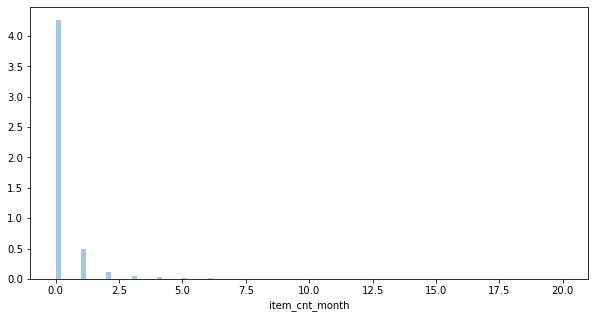

In [22]:
plt.figure(figsize = (10,5))
sns.distplot(matrix['item_cnt_month'], bins = 100)

Majority of the target is 0.

### Test set

Now let us also append the test set to the aggregated data. 

In [23]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.drop('ID', axis = 1, inplace = True)

ts = time.time()
matrix = pd.concat([matrix, test], ignore_index = True, sort = False)
matrix.fillna(0, inplace = True) #fill the target of test set with 0 for now
print(f'Time elapsed is {time.time()- ts}')
matrix.head()

Time elapsed is 0.036408185958862305


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [24]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_cnt_month  float16
dtypes: float16(1), int16(1), int8(2)
memory usage: 63.7 MB


### Shops/Items/Cats features

Next let us add the shops/items/cats features.

In [25]:
ts = time.time()
matrix = pd.merge(matrix, shops[['shop_id','city_code']], on=['shop_id'], how='left')
matrix = pd.merge(matrix, items[['item_id','item_category_id']], on=['item_id'], how='left')
matrix = pd.merge(matrix, cats[['item_category_id','type_code','subtype_code']], on=['item_category_id'], how='left')

matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
print(f'Time elapsed is {time.time() - ts}')
print('Missing values:')
matrix.isnull().sum()

Time elapsed is 1.9927070140838623
Missing values:


date_block_num      0
shop_id             0
item_id             0
item_cnt_month      0
city_code           0
item_category_id    0
type_code           0
subtype_code        0
dtype: int64

In [26]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,29,40,11,4
1,0,0,27,0.0,29,19,5,10
2,0,0,28,0.0,29,30,8,55
3,0,0,29,0.0,29,23,5,16
4,0,0,32,6.0,29,40,11,4


Let's look at which shop has sold the most items. 

<BarContainer object of 60 artists>

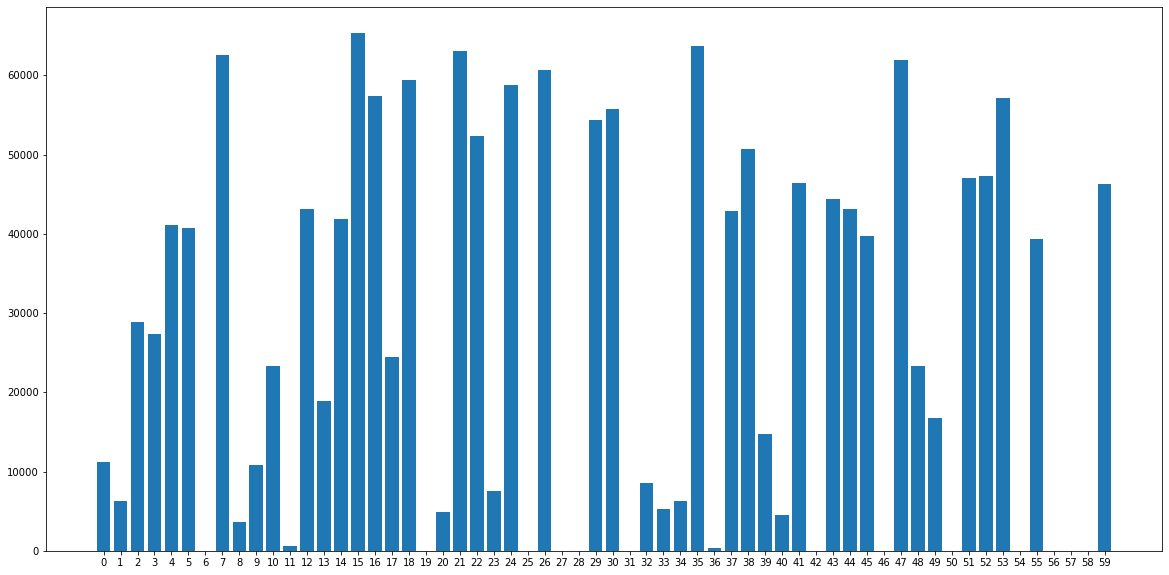

In [27]:
gb = matrix.groupby('shop_id').agg({'item_cnt_month':'sum'}).reset_index()
gb['shop_id'] = gb['shop_id'].astype(str)
fig = plt.figure(figsize = (20,10))
plt.bar(gb['shop_id'], gb['item_cnt_month'])

### Target lags

Next we will create target-lagged features. The idea is to keep track of the amount of items sold for the previous months.

In [28]:
def lag_feature(df: pd.DataFrame, lags: list, col: str) -> pd.DataFrame:
    """
    This function creates lag features based on 'col'. Note that it will not change the original dataframe
    Args:
        df (DataFrame): the input data set
        lags (list): list of integers
        col (str): column on which to create lag features
    Returns:
        original df with the lag features
    """
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    df_1 = df.copy()
    for i in tqdm(lags):
        shifted = tmp.copy()
        shifted.rename(columns = {col: col+'_lag_'+str(i)}, inplace = True)
        shifted['date_block_num'] += i 
        df_1 = pd.merge(df_1, shifted, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
    return df_1

In [29]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 5/5 [00:19<00:00,  3.92s/it]

Elapsed time is 19.643439292907715


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN


### Mean Encoded Features

Next we create mean encoded features for different combinations of categorical variables. Note that to avoid target leakage we also apply lag in this case.

In [30]:
def mean_encoded_lag(df: pd.DataFrame, cat_fea: list, lags: list, col: str, agg: str, output_col: str) -> pd.DataFrame:
    """
    This function creates mean encoded features with lags. Note that it will not change the original dataframe
    Args:
       df (DataFrame): the original dataframe
       cat_fea (list): list of categorical features to do groupby
       lags (list): list of integers (amounts of lags)
       col (str): the name of the target column
       agg (str): the aggregation method: 'mean', 'median', 'sum' etc. 
       output_col (str): name of the mean_encoded feature
    Returns
       original df with the mean encoded features
    """
    group = df.groupby(cat_fea).agg({col: agg}).reset_index()
    group.rename(columns = {col: output_col}, inplace = True)
    
    df_1 = df.copy()
    df_1 = pd.merge(df_1, group, on = cat_fea, how = 'left')
    df_1[output_col] = df_1[output_col].astype(np.float16)
    df_1 = lag_feature(df_1, lags, output_col)
    df_1.drop(output_col, axis = 1, inplace = True)
    
    return df_1

Create mean_encoded features for date_block_num, lag by 1 month.

In [31]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num'], [1], 'item_cnt_month', 'mean', 'date_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

Elapsed time is 5.538010120391846


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded feature for [date_block_num, item_id], lagged by [1,2,3,6,12] months

In [32]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'item_id'], [1,2,3,6,12], 'item_cnt_month', 'mean', 'date_item_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Elapsed time is 22.353398323059082


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for [date_block_num, shop_id], lagged by [1,2,3,6,12] months. 

In [33]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'shop_id'], [1,2,3,6,12], 'item_cnt_month', 'mean', 'date_shop_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


Elapsed time is 23.041471481323242


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'item_category_id'], lagged by 1 month.

In [34]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'item_category_id'], [1], 'item_cnt_month', 'mean', 'date_cat_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Elapsed time is 6.926326513290405


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'shop_id', 'item_category_id'], lagged by 1 month.

In [35]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'shop_id', 'item_category_id'], [1], 'item_cnt_month', 'mean', 'date_shop_cat_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Elapsed time is 7.277358770370483


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'shop_id', 'type_code']. lagged by 1 month.

In [36]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'shop_id', 'type_code'], [1], 'item_cnt_month', 'mean', 'date_shop_type_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Elapsed time is 7.398403167724609


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'shop_id', 'subtype_code'], lagged by 1 month.

In [37]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'shop_id', 'subtype_code'], [1], 'item_cnt_month', 'mean', 'date_shop_subtype_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


Elapsed time is 7.4510979652404785


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'city_code'], lagged by 1 month.

In [38]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'city_code'], [1], 'item_cnt_month', 'mean', 'date_city_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


Elapsed time is 7.3714759349823


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'item_id', 'city_code'], lagged by 1 month.

In [39]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'item_id', 'city_code'], [1], 'item_cnt_month', 'mean', 'date_item_city_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Elapsed time is 11.187082290649414


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'type_code'], lagged by 1 month.

In [40]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'type_code'], [1], 'item_cnt_month', 'mean', 'date_type_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


Elapsed time is 7.587113857269287


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create mean encoded features for ['date_block_num', 'subtype_code'], lagged by 1 month.

In [41]:
ts = time.time()
matrix = mean_encoded_lag(matrix, ['date_block_num', 'subtype_code'], [1], 'item_cnt_month', 'mean', 'date_subtype_avg_item_cnt')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


Elapsed time is 7.694794654846191


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have created a bunch of encoded features. Note that because we need to compute lags, we need to include 'date_block_num' in all of those features. 

### Trend features

First we compute the item price trend for the past 6 months. More specifically we only capture the latest price change in the past 6 months. We aggregate the item_price from the train data and then merge it to the matrix data. This is better than first merging to item_price to the matrix data and then aggregate because there might be a lot of null values when we compute the average. 

In [42]:
ts = time.time()
#aggregate item price
group = train.groupby(['item_id']).agg({'item_price': 'mean'}).reset_index()
group.rename(columns = {'item_price': 'item_avg_item_price'}, inplace = True)

#merge average item price to the whole data
matrix = pd.merge(matrix, group, on = ['item_id'], how = 'left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

#aggregate item price based on ['date_block_num','item_id']
group = train.groupby(['date_block_num','item_id']).agg({'item_price':'mean'}).reset_index()
group.rename(columns = {'item_price': 'date_item_avg_item_price'}, inplace = True)

#merge to the whole data
matrix = pd.merge(matrix, group, on = ['date_block_num', 'item_id'], how = 'left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    #this compute the change in price for each month compared to the average price
    matrix['delta_price_lag_' + str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)]-matrix['item_avg_item_price'])/matrix['item_avg_item_price']
    
def select_trend(row):
    """
    This function returns the first non-null delta_price_lag, otherwise it returns 0
    """
    for i in lags:
        if row['delta_price_lag_'+ str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis = 1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace = True)

#drop the lagged features, we only need the delta_price_lag
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_' + str(i)]
    features_to_drop += ['delta_price_lag_' + str(i)]
    
matrix.drop(features_to_drop, axis = 1, inplace = True)
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


Elapsed time is 230.9800910949707


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Next let us create last month shop revenue trend. More specifically for each shop_id we compute the delta between shop_id revenue for that month and the avg shop_id revenue for the months 0 to 33. Again the average should be done on the train set and not on the matrix dataset (because the matrix dataset also contains the test set). We then lag everything by a month, i.e. we only know the delta revenue from the previous month. 

In [43]:
#create the revenue feature
train['revenue'] = train['item_price']*train['item_cnt_day']

ts = time.time()
#create shop revenue per month
group = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': 'sum'}).reset_index()
group.rename(columns= {'revenue': 'date_shop_revenue'}, inplace = True)

matrix = pd.merge(matrix, group, on = ['date_block_num', 'shop_id'], how = 'left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

#create avg shop revenue per month
group = group.groupby(['shop_id']).agg({'date_shop_revenue': 'mean'}).reset_index()
group.rename(columns = {'date_shop_revenue': 'shop_avg_revenue'}, inplace = True)

matrix = pd.merge(matrix, group, on = ['shop_id'], how = 'left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

#create delta between shop revenue per month and avg shop revenue
matrix['delta_revenue'] = (matrix['date_shop_revenue']-matrix['shop_avg_revenue'])/matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

#create lag delta
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis =1, inplace = True)

print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Elapsed time is 8.960239171981812


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


### Special features

Next we create a feature that records the number of months since the previous sale. We use a HashTable (a fancy word for a dictionary) with keys (item_id, shop_id). If we (item_id, shop_id) is not in the HashTable we put the value date_block_num, if it is already in the HashTable we compute the difference between the latest date_block_num and the previous one. Then to avoid target leakage we lag by 1 month. 

In [45]:
ts = time.time()
cache = defaultdict(lambda: 0)
matrix['item_shop_last_sale'] = 0
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id) + ' '+ str(row.shop_id) #key is item_id and shop_id
    if cache[key] == 0:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num #record the first month that an item_id is sold by shop_id
    else:
        last_date_block_num = cache[key] #get the latest month item_id is sold by shop_id
        #get the number of months since last sale
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num #at is a fast .loc https://stackoverflow.com/questions/28757389/pandas-loc-vs-iloc-vs-ix-vs-at-vs-iat
        cache[key] = row.date_block_num #update the month 
        
matrix = lag_feature(matrix, [1], 'item_shop_last_sale')
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:05<00:00,  5.07s/it]

Elapsed time is 959.8412878513336


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_shop_last_sale_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN


Next we create a similar HashTable, but this time the keys are just item_id instead of (item_id, shop_id). In other words we look at the number of months since the previous sales of each item, irrespective of shop_id. 

In [47]:
ts = time.time()
cache = defaultdict(lambda: 0)
matrix['item_last_sale'] = 0
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id #key is item_id
    if cache[key] == 0:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num #record the first month that an item_id is sold
    else:
        last_date_block_num = cache[key] #get the latest month item_id is sold 
        #get the number of months since last sale
        matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num #at is a fast .loc https://stackoverflow.com/questions/28757389/pandas-loc-vs-iloc-vs-ix-vs-at-vs-iat
        cache[key] = row.date_block_num #update the month 
        
matrix = lag_feature(matrix, [1], 'item_last_sale')
matrix.drop('item_last_sale', axis = 1, inplace = True)
print(f'Elapsed time is {time.time()-ts}')
matrix.head()

100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


Elapsed time is 964.4911935329437


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_shop_last_sale_lag_1,item_last_sale_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN


Create the month feature

In [48]:
matrix['month'] = matrix['date_block_num'] % 12
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_shop_last_sale_lag_1,item_last_sale_lag_1,month
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0


Number of days in a month, no leap years. 

In [49]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
#here 0 is the January and 11 is December
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_shop_last_sale_lag_1,item_last_sale_lag_1,month,days
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31


Months since first sale for each shop/item pair and for item only. Note that this is not entirely accurate because a shop/item pair can appear even though item_cnt_month = 0. We do not need to create lag because we do not use the target for this case. 

In [50]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

print(f'Elapsed time is {time.time()-ts}')
matrix.head()

Elapsed time is 1.0630226135253906


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_shop_last_sale_lag_1,item_last_sale_lag_1,month,days,item_shop_first_sale,item_first_sale
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31,0,0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31,0,0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31,0,0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31,0,0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,0,31,0,0


### Final preparations

Since we look back at the past 12 months we will consider data from the second year onward. 

In [51]:
ts = time.time()
matrix = matrix[matrix['date_block_num'] > 11]
print(f'Elapsed time is {time.time()-ts}')
print(f'The shape of matrix is {matrix.shape}')

Elapsed time is 0.4273228645324707
The shape of matrix is (6639294, 41)


Fill in the lag columns from item_cnt_month with 0. 

In [52]:
ts = time.time()

for col in tqdm(matrix.columns):
    if ('_lag_' in col) and (matrix[col].isnull().any()):
        if 'item_cnt' in col:
            matrix[col].fillna(0, inplace = True)
            
print(f'Elapsed time is {time.time()-ts}')
matrix.isnull().sum().sort_values(ascending = False)

100%|██████████| 41/41 [00:00<00:00, 45.84it/s] 


Elapsed time is 0.8959558010101318


item_last_sale_lag_1                    1407394
item_shop_last_sale_lag_1               1407394
delta_revenue_lag_1                     1407394
item_first_sale                               0
item_cnt_month_lag_2                          0
date_item_avg_item_cnt_lag_3                  0
date_item_avg_item_cnt_lag_2                  0
date_item_avg_item_cnt_lag_1                  0
date_avg_item_cnt_lag_1                       0
item_cnt_month_lag_12                         0
item_cnt_month_lag_6                          0
item_cnt_month_lag_3                          0
subtype_code                                  0
item_cnt_month_lag_1                          0
date_item_avg_item_cnt_lag_12                 0
type_code                                     0
item_category_id                              0
city_code                                     0
item_cnt_month                                0
item_id                                       0
shop_id                                 

In [53]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

### Save the data

In [54]:
matrix.to_pickle('data/sale_data.pickle')
del matrix
del cache
del group
del items
del shops
del cats
del train
del test
gc.collect()